In [1]:
import pandas as pd
import numpy as np
import json
import mne
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [36]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

print(__doc__)

# #############################################################################
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.
tmin, tmax = -1., 4.
event_id = dict(left=2, right=3)
subject = [1]
# subject = 1
runs = [4, 8, 12]  # motor imagery: left vs right hand

raw_fnames = [f'../datasets/bci2000-mi/S{subj:03d}/S{subj:03d}R{run:02d}.edf' for run in runs for subj in subject]
# marker_fnames = [f'../datasets/bci2000-mi/S{subj:03d}/S{subj:03d}R{subj:02d}.vmrk' for run in runs for subj in subject]

# raw_fnames = eegbci.load_data(subject, runs, path='../datasets/')
print(raw_fnames)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
eegbci.standardize(raw)  # set channel names
montage = make_standard_montage('standard_1005')
raw.set_montage(montage)



Automatically created module for IPython interactive environment
['../datasets/bci2000-mi/S001/S001R04.edf', '../datasets/bci2000-mi/S001/S001R08.edf', '../datasets/bci2000-mi/S001/S001R12.edf']
Extracting EDF parameters from /Users/anushmutyala/Documents/GitHub/Energy-Efficient-Decoding-of-EEG-Motor-Imagery-using-Spiking-Legendre-Memory-Units/datasets/bci2000-mi/S001/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/anushmutyala/Documents/GitHub/Energy-Efficient-Decoding-of-EEG-Motor-Imagery-using-Spiking-Legendre-Memory-Units/datasets/bci2000-mi/S001/S001R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/anushmutyala/Documents/GitHub/Energy-Efficient-Decoding-of-EEG-Motor-Imagery-using-Spiking-Legendre-Memory-

<RawEDF | S001R04.edf, 64 x 60000 (375.0 s), ~29.4 MB, data loaded>

In [37]:
raw.annotations

<Annotations | 94 segments: BAD boundary (2), EDGE boundary (2), T0 (45), ...>

In [38]:
# Apply band-pass filter
raw.filter(8., 30., fir_design='firwin', skip_by_annotation='edge')

events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                baseline=None, preload=True)
epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
labels = epochs.events[:, -1] - 2

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 801 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


In [39]:
epochs_data = epochs_train.get_data()
print(epochs_data.shape)


(45, 64, 161)


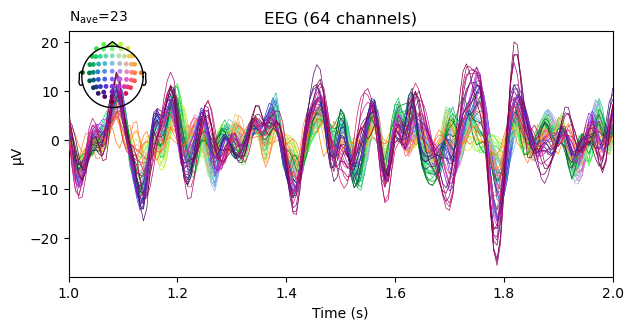

In [40]:
epochs_train['left'].average().plot();

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


/Users/anushmutyala/opt/miniconda3/envs/torch/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


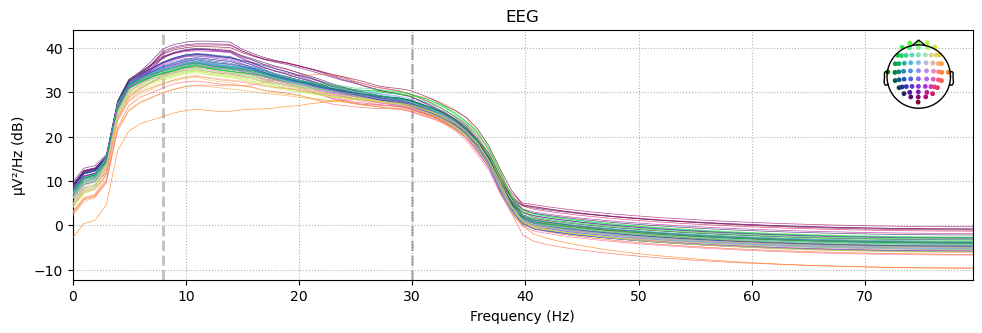

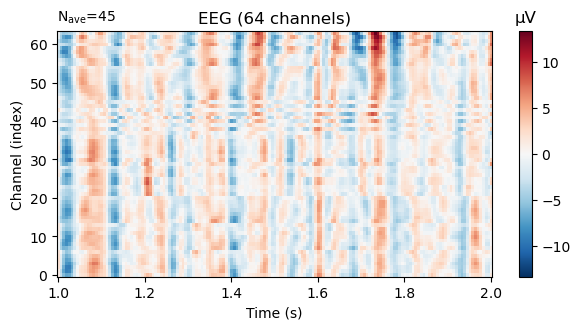

In [41]:
epochs_train.plot_psd();
epochs_train.average().plot_image();